In [1]:
import torch
import torch.nn as nn
from torchinfo import summary


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
# Load the dataset

train_data=pd.read_csv("../dataset/train_val.csv")
dataset_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "dataset")


In [3]:
import hydra
from omegaconf import DictConfig
import os
import hydra

from torchvision import transforms as T

train_transform = T.Compose([
    # resize 
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])
test_transform = T.Compose([
    # resize 
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
import os


In [4]:
from torch.utils.data import DataLoader
import torch
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from data.dataset import Dataset



class DataModule:
    def __init__(
        self,
        dataset_path=dataset_path,
        train_transform=train_transform,
        test_transform=test_transform,
        batch_size=32,
        num_workers=4,
        metadata=["title"],
    ):
        self.dataset_path = dataset_path
        self.train_transform = train_transform  
        self.test_transform = test_transform
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.metadata = metadata
        
        # Create train and val datasets in a single operation using the factory method
        self.train, self.val = Dataset.create_train_val_datasets(
            self.dataset_path,
            self.train_transform,
            self.metadata,
            val_year_min=2023
        )

    def train_dataloader(self):
        """Train dataloader."""
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        """Validation dataloader."""
        if self.val is None:
            return None
        return DataLoader(
            self.val,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )
    
    def test_dataloader(self):
        """Test dataloader."""
        dataset = Dataset(
            self.dataset_path,
            "test",
            transforms=self.test_transform,
            metadata=self.metadata,
            split_ratio=1,
            train_or_val_or_test="test"
        )
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

In [5]:
os.chdir("..")
datamodule = DataModule( 
    dataset_path="dataset",
)
train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()



dataset/train_val.csv


2025-05-26 00:50:49,948 - INFO - train set (until 2022): {'high': 43.65367180417044, 'viral': 22.65034753702025, 'medium': 20.9579933514657, 'top': 8.64309459051073, 'low': 4.09489271683288}
2025-05-26 00:50:49,949 - INFO - val set (from 2023): {'medium': 38.02315227070348, 'high': 36.01959038290294, 'viral': 14.33659839715049, 'low': 7.079252003561888, 'top': 4.541406945681211}


dataset/train_val.csv


2025-05-26 00:50:50,289 - INFO - train set (until 2022): {'high': 43.65367180417044, 'viral': 22.65034753702025, 'medium': 20.9579933514657, 'top': 8.64309459051073, 'low': 4.09489271683288}
2025-05-26 00:50:50,290 - INFO - val set (from 2023): {'medium': 38.02315227070348, 'high': 36.01959038290294, 'viral': 14.33659839715049, 'low': 7.079252003561888, 'top': 4.541406945681211}


dataset/train_val.csv


2025-05-26 00:50:50,674 - INFO - train set (until 2022): {'high': 43.65367180417044, 'viral': 22.65034753702025, 'medium': 20.9579933514657, 'top': 8.64309459051073, 'low': 4.09489271683288}
2025-05-26 00:50:50,675 - INFO - val set (from 2023): {'medium': 38.02315227070348, 'high': 36.01959038290294, 'viral': 14.33659839715049, 'low': 7.079252003561888, 'top': 4.541406945681211}


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import timm
# === 1. Download et préprocess MNIST/FashionMNIST en 3 canaux / 224x224 ===

import torch
import torch.nn as nn
import torchvision.models as models

class ResNetUNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        resnet =models.resnet18(pretrained=True)
        # Encoder (on récupère les features de chaque bloc pour les skip connections)
        self.enc1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)           # 64, 112x112
        self.enc2 = nn.Sequential(resnet.maxpool, resnet.layer1)                   # 64, 56x56
        self.enc3 = resnet.layer2                                                 # 128, 28x28
        self.enc4 = resnet.layer3                                                 # 256, 14x14
        self.enc5 = resnet.layer4                                                 # 512, 7x7

    def forward(self, x):
        x1 = self.enc1(x)      # 112x112
        x2 = self.enc2(x1)     # 56x56
        x3 = self.enc3(x2)     # 28x28
        x4 = self.enc4(x3)     # 14x14
        x5 = self.enc5(x4)     # 7x7
        return x1, x2, x3, x4, x5

class UNetDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.up1 = self.upsample_block(512, 256)    # 512 -> 256
        self.up1_conv1x1 = nn.Conv2d(256+256, 256, 1)  # Reduce concatenated channels
        
        self.up2 = self.upsample_block(256, 128)    # 256 -> 128
        self.up2_conv1x1 = nn.Conv2d(128+128, 128, 1)  # Reduce concatenated channels
        
        self.up3 = self.upsample_block(128, 64)     # 128 -> 64
        self.up3_conv1x1 = nn.Conv2d(64+64, 64, 1)   # Reduce concatenated channels
        
        self.up4 = self.upsample_block(64, 64)      # 64 -> 64
        self.up4_conv1x1 = nn.Conv2d(64+64, 64, 1)   # Reduce concatenated channels
        
        self.final_up = nn.ConvTranspose2d(64, 3, 4, 2, 1)  # Final upsampling to RGB

    def upsample_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x1, x2, x3, x4, x5):
        # x5: (B, 512, 7, 7) - deepest features
        # x4: (B, 256, 14, 14)
        # x3: (B, 128, 28, 28) 
        # x2: (B, 64, 56, 56)
        # x1: (B, 64, 112, 112)
        
        d1 = self.up1(x5)                   # (B, 256, 14, 14)
        d1 = torch.cat([d1, x4], dim=1)     # (B, 512, 14, 14)
        d1 = self.up1_conv1x1(d1)           # (B, 256, 14, 14)

        d2 = self.up2(d1)                   # (B, 128, 28, 28)
        d2 = torch.cat([d2, x3], dim=1)     # (B, 256, 28, 28)
        d2 = self.up2_conv1x1(d2)           # (B, 128, 28, 28)

        d3 = self.up3(d2)                   # (B, 64, 56, 56)
        d3 = torch.cat([d3, x2], dim=1)     # (B, 128, 56, 56)
        d3 = self.up3_conv1x1(d3)           # (B, 64, 56, 56)

        d4 = self.up4(d3)                   # (B, 64, 112, 112)
        d4 = torch.cat([d4, x1], dim=1)     # (B, 128, 112, 112)
        d4 = self.up4_conv1x1(d4)           # (B, 64, 112, 112)

        out = self.final_up(d4)             # (B, 3, 224, 224)
        out = torch.sigmoid(out)
        return out

class ResNetUNetAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ResNetUNetEncoder()
        self.decoder = UNetDecoder()
    def forward(self, x):
        x1, x2, x3, x4, x5 = self.encoder(x)
        out = self.decoder(x1, x2, x3, x4, x5)
        return out# === 3. Train Autoencoder ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetUNetAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# X = X.to(device)

epochs = 5
model.train()
import tqdm
for epoch in range(epochs):
    optimizer.zero_grad()
    for batch in tqdm.tqdm(train_loader):
        batch_image=batch["image"].to(device)
        recon = model(batch_image)
        loss = loss_fn(recon, batch_image)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs} -- MSE loss: {loss.item():.5f}")



100%|██████████| 414/414 [00:38<00:00, 10.87it/s]


Epoch 1/50 -- MSE loss: 2.14870


100%|██████████| 414/414 [00:37<00:00, 10.93it/s]


Epoch 2/50 -- MSE loss: 2.48860


100%|██████████| 414/414 [00:38<00:00, 10.89it/s]


Epoch 3/50 -- MSE loss: 2.24401


100%|██████████| 414/414 [00:36<00:00, 11.27it/s]


Epoch 4/50 -- MSE loss: 2.28445


100%|██████████| 414/414 [00:37<00:00, 11.00it/s]


Epoch 5/50 -- MSE loss: 2.25760


100%|██████████| 414/414 [00:37<00:00, 10.91it/s]


Epoch 6/50 -- MSE loss: 2.37507


100%|██████████| 414/414 [00:37<00:00, 10.90it/s]


Epoch 7/50 -- MSE loss: 2.42995


 15%|█▍        | 61/414 [00:05<00:33, 10.52it/s]


KeyboardInterrupt: 

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from typing import Tuple, List

# === Attention Module (inspired by CBAM) ===
class ChannelAttention(nn.Module):
    def __init__(self, channels: int, reduction: int = 16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size: int = 7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return x * self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.channel_attention = ChannelAttention(channels)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

# === Residual Block with Attention ===
class ResidualBlock(nn.Module):
    def __init__(self, channels: int, use_attention: bool = True):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)
        self.attention = CBAM(channels) if use_attention else nn.Identity()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.attention(out)
        out = out + residual
        return self.relu(out)

# === Advanced Encoder (EfficientNet-inspired + Attention) ===
class AdvancedEncoder(nn.Module):
    def __init__(self, input_channels: int = 3, latent_dim: int = 512):
        super().__init__()
        # Use EfficientNet-B3 as backbone (good balance between size and performance)
        efficientnet = models.efficientnet_b3(pretrained=True)
        self.features = efficientnet.features
        
        # Add attention modules at key layers
        self.attention_layers = nn.ModuleList([
            CBAM(40),   # After block 2
            CBAM(80),   # After block 3  
            CBAM(112),  # After block 4
            CBAM(192),  # After block 5
            CBAM(320),  # After block 6
        ])
        
        # Bottleneck to latent space
        self.bottleneck = nn.Sequential(
            nn.AdaptiveAvgPool2d((4, 4)),  # Global spatial compression
            nn.Conv2d(1536, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, latent_dim, 3, padding=1),
            nn.BatchNorm2d(latent_dim),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        skip_connections = []
        
        # Pass through EfficientNet blocks with attention
        for i, layer in enumerate(self.features):
            x = layer(x)
            
            # Add attention and collect skip connections at specific layers
            if i in [2, 3, 4, 5, 6]:  # Key feature extraction points
                attention_idx = [2, 3, 4, 5, 6].index(i)
                x = self.attention_layers[attention_idx](x)
                skip_connections.append(x)
        
        # Compress to latent space
        latent = self.bottleneck(x)
        
        return latent, skip_connections

# === Advanced Decoder with Skip Connections ===
class AdvancedDecoder(nn.Module):
    def __init__(self, latent_dim: int = 512, output_channels: int = 3):
        super().__init__()
        
        # Latent expansion
        self.latent_expand = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 1024, 4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )
        
        # Decoder blocks with skip connections
        self.decoder_blocks = nn.ModuleList([
            self._make_decoder_block(1024 + 320, 512),  # Skip from encoder block 6
            self._make_decoder_block(512 + 192, 256),   # Skip from encoder block 5
            self._make_decoder_block(256 + 112, 128),   # Skip from encoder block 4
            self._make_decoder_block(128 + 80, 64),     # Skip from encoder block 3
            self._make_decoder_block(64 + 40, 32),      # Skip from encoder block 2
        ])
        
        # Residual refinement blocks
        self.refinement = nn.Sequential(
            ResidualBlock(32),
            ResidualBlock(32),
            ResidualBlock(32, use_attention=False),
        )
        
        # Final output layers
        self.final_layers = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, output_channels, 3, padding=1),
            nn.Sigmoid()  # Output in [0,1] range
        )
        
    def _make_decoder_block(self, in_channels: int, out_channels: int):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            ResidualBlock(out_channels),
        )
    
    def forward(self, latent: torch.Tensor, skip_connections: List[torch.Tensor]):
        x = self.latent_expand(latent)
        
        # Decode with skip connections (reverse order)
        for i, decoder_block in enumerate(self.decoder_blocks):
            if i < len(skip_connections):
                skip = skip_connections[-(i+1)]  # Reverse order
                # Resize skip connection if needed
                if x.shape[2:] != skip.shape[2:]:
                    skip = F.interpolate(skip, size=x.shape[2:], mode='bilinear', align_corners=False)
                x = torch.cat([x, skip], dim=1)
            x = decoder_block(x)
        
        # Refinement
        x = self.refinement(x)
        
        # Final output
        output = self.final_layers(x)
        
        return output

# === Perceptual Loss (VGG-based) ===
class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features
        self.feature_layers = nn.ModuleList([
            vgg[:4],   # conv1_2
            vgg[:9],   # conv2_2
            vgg[:18],  # conv3_4
            vgg[:27],  # conv4_4
        ])
        
        # Freeze VGG parameters
        for param in self.parameters():
            param.requires_grad = False
            
    def forward(self, input_img: torch.Tensor, target_img: torch.Tensor):
        loss = 0.0
        x_input, x_target = input_img, target_img
        
        for layer in self.feature_layers:
            x_input = layer(x_input)
            x_target = layer(x_target)
            loss += F.mse_loss(x_input, x_target)
            
        return loss / len(self.feature_layers)

# === Complete Autoencoder ===
class YouTubeThumbnailAutoencoder(nn.Module):
    def __init__(self, latent_dim: int = 512, input_channels: int = 3):
        super().__init__()
        self.encoder = AdvancedEncoder(input_channels, latent_dim)
        self.decoder = AdvancedDecoder(latent_dim, input_channels)
        self.latent_dim = latent_dim
        
    def forward(self, x: torch.Tensor):
        latent, skip_connections = self.encoder(x)
        reconstructed = self.decoder(latent, skip_connections)
        return reconstructed
    
    def encode(self, x: torch.Tensor):
        """Extract latent representation"""
        latent, _ = self.encoder(x)
        return latent
    
    def decode(self, latent: torch.Tensor, skip_connections: List[torch.Tensor] = None):
        """Decode from latent representation"""
        if skip_connections is None:
            # If no skip connections provided, use zeros (less optimal but functional)
            skip_connections = []
        return self.decoder(latent, skip_connections)

# === Combined Loss Function ===
class CombinedLoss(nn.Module):
    def __init__(self, perceptual_weight: float = 0.1, ssim_weight: float = 0.1):
        super().__init__()
        self.perceptual_loss = PerceptualLoss()
        self.mse_loss = nn.MSELoss()
        self.perceptual_weight = perceptual_weight
        self.ssim_weight = ssim_weight
        
    def ssim_loss(self, x: torch.Tensor, y: torch.Tensor):
        """Simplified SSIM loss"""
        mu_x = F.avg_pool2d(x, 3, 1, 1)
        mu_y = F.avg_pool2d(y, 3, 1, 1)
        
        sigma_x = F.avg_pool2d(x * x, 3, 1, 1) - mu_x * mu_x
        sigma_y = F.avg_pool2d(y * y, 3, 1, 1) - mu_y * mu_y
        sigma_xy = F.avg_pool2d(x * y, 3, 1, 1) - mu_x * mu_y
        
        c1, c2 = 0.01**2, 0.03**2
        ssim_map = ((2 * mu_x * mu_y + c1) * (2 * sigma_xy + c2)) / \
                   ((mu_x**2 + mu_y**2 + c1) * (sigma_x + sigma_y + c2))
        
        return 1 - ssim_map.mean()
    
    def forward(self, reconstructed: torch.Tensor, target: torch.Tensor):
        mse = self.mse_loss(reconstructed, target)
        perceptual = self.perceptual_loss(reconstructed, target)
        ssim = self.ssim_loss(reconstructed, target)
        
        total_loss = mse + self.perceptual_weight * perceptual + self.ssim_weight * ssim
        
        return {
            'total': total_loss,
            'mse': mse,
            'perceptual': perceptual,
            'ssim': ssim
        }

# === Training Setup Function ===
def create_model_and_optimizer(latent_dim: int = 512, lr: float = 1e-4):
    """Create model, optimizer, and loss function"""
    model = YouTubeThumbnailAutoencoder(latent_dim=latent_dim)
    
    # Use different learning rates for encoder and decoder
    optimizer = torch.optim.AdamW([
        {'params': model.encoder.parameters(), 'lr': lr * 0.1},  # Lower LR for pretrained encoder
        {'params': model.decoder.parameters(), 'lr': lr}
    ], weight_decay=1e-4)
    
    loss_fn = CombinedLoss(perceptual_weight=0.1, ssim_weight=0.1)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
    
    return model, optimizer, loss_fn, scheduler

# # === Example Usage ===
# if __name__ == "__main__":
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     # Create model
#     model, optimizer, loss_fn, scheduler = create_model_and_optimizer(latent_dim=512)
#     model = model.to(device)
    
#     # Example forward pass
#     x = torch.randn(4, 3, 224, 224).to(device)  # Batch of thumbnail images
    
#     # Forward pass
#     reconstructed = model(x)
#     print(f"Input shape: {x.shape}")
#     print(f"Reconstructed shape: {reconstructed.shape}")
    
#     # Compute loss
#     losses = loss_fn(reconstructed, x)
#     print(f"Total loss: {losses['total']:.4f}")
#     print(f"MSE: {losses['mse']:.4f}")
#     print(f"Perceptual: {losses['perceptual']:.4f}")
#     print(f"SSIM: {losses['ssim']:.4f}")
    
#     # Extract latent representation
#     latent = model.encode(x)
#     print(f"Latent shape: {latent.shape}")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, optimizer, loss_fn, scheduler = create_model_and_optimizer(latent_dim=512)
model = model.to(device)

import tqdm
# Entraînement
for epoch in range(num_epochs):
    for batch in tqdm.tqdm(train_loader):
        batch_image = batch["image"].to(device)
        
        # Forward pass
        reconstructed = model(batch_image)
        
        # Compute loss
        losses = loss_fn(reconstructed, batch_image)
        loss = losses['total']
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    scheduler.step()


In [16]:
# Calculer et afficher le nombre de paramètres du modèle
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params
  
count_parameters(model)

(27953715, 27953715)

2025-05-26 02:32:11,911 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
2025-05-26 02:32:11,923 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.3611329].
2025-05-26 02:32:11,933 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.8099348].
2025-05-26 02:32:11,944 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4308496].


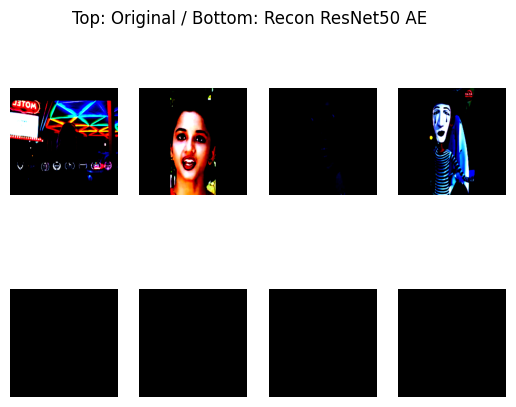

In [15]:
# === 4. Visualisation reconstruction ===
model.eval()
X_test=next(iter(val_loader))["image"].to(device)
with torch.no_grad():
    recon = model(X_test)
for i in range(4):
    # plt.figure(figsize=(10, 5))
    plt.subplot(2,4,i+1)
    plt.imshow(X_test[i].permute(1,2,0).cpu().numpy())
    plt.axis('off')
    plt.subplot(2,4,4+i+1)
    plt.imshow(recon[i].permute(1,2,0).cpu().numpy())
    plt.axis('off')
plt.suptitle("Top: Original / Bottom: Recon ResNet50 AE")
plt.show()